In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')
data_small_dir = os.path.join(project_root, 'synth_data')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, mbconv_base,train_model,simple_base

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


2025-01-27 13:11:05.111847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737979865.122537 1085948 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737979865.125792 1085948 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 13:11:05.137727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1737979867.285184 1085948 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11

In [3]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')
test_synth_dir = os.path.join(data_small_dir, 'test')

In [4]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE
temperature = 0.15

In [5]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir,batch_size=32)
validation_dataset = get_augmented_dataset(val_dir,batch_size=32,shuffle=True)
test_dataset = get_augmented_dataset(test_dir,batch_size=32,shuffle=False)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1,shuffle=False)




Found 73230 files belonging to 2 classes.
Found 36545 files belonging to 2 classes.
Found 19343 files belonging to 2 classes.
Found 399 files belonging to 2 classes.


In [6]:
from models import get_fcn_model,get_supervised_contrastive_loss
fcn_modelmbconv = get_fcn_model(mbconv_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2)


In [7]:
fcn_modelmbconv.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 14, 14, 128)    │       274,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,592 (1.11 MB)

 Trainable params: 282,080 (1.08 MB)

 Non-trainable params: 8,512 (33.25 KB)

In [8]:
test_synth_dataset_shuffled = get_augmented_dataset(test_synth_dir,batch_size=4,shuffle=True)
test_small_dataset_shuffled = get_augmented_dataset(test_small_dir,batch_size=1,shuffle=True)

Found 399 files belonging to 2 classes.
Found 399 files belonging to 2 classes.


In [10]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [ ]:

fcn_modelmbconv.compile(
    optimizer=optimizer,
    loss=get_supervised_contrastive_loss(0.15)
)


In [11]:
fcn_modelmbconv.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 14, 14, 128)    │       274,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,592 (1.11 MB)

 Trainable params: 282,080 (1.08 MB)

 Non-trainable params: 8,512 (33.25 KB)

In [12]:
import os
from models import get_fcn_model,get_supervised_contrastive_loss
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True,
    mode="min"
)


fcn_modelb = fcn_modelmbconv.fit(train_dataset,callbacks=[early_stopping],epochs=25)

Epoch 1/250


2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.8487
Epoch 2/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.8388
Epoch 3/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.8290
Epoch 4/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.8216
Epoch 5/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.8187
Epoch 6/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.8129
Epoch 7/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.8085
Epoch 8/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 107s 46ms/step - loss: 2.8049
Epoch 9/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.8057
Epoch 10/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.7996
Epoch 11/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step - loss: 2.7944
Epoch 12/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 107s 46ms/step - loss: 2.7943
Epoch 13/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 107s 47ms/step - loss: 2.7902
Epoch 14/250
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 106s 46ms/step 

In [13]:
checkpoint_path = "./checkpoints/fcn_mbconv.weights.h5"
fcn_modelmbconv.save_weights(checkpoint_path)

In [7]:
checkpoint_path = "./checkpoints/fcn_mbconv.weights.h5"
fcn_modelmbconv.load_weights(checkpoint_path)

In [22]:
from keras.layers import GlobalAveragePooling2D,Dropout,Dense,Input
last_mbconv_layer_name = 'functional_1'  # Example name
last_mbconv_layer = fcn_modelmbconv.get_layer(last_mbconv_layer_name)

# Create a new model that outputs up to the last mbconv_block
inputs = Input(shape=(224,224,3))

for layer in fcn_modelmbconv.layers:
    layer.trainable = False
base = last_mbconv_layer(inputs)

x = GlobalAveragePooling2D()(base)
x = Dropout(rate=0.3)(x)
outputs = Dense(2, activation="sigmoid")(x)
fcn_model = Model(inputs=inputs,outputs = outputs)
fcn_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 14, 14, 128)    │       274,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,338 (1.05 MB)

 Trainable params: 258 (1.01 KB)

 Non-trainable params: 274,080 (1.05 MB)

In [12]:
truncated_model.summary()

Model: "truncated_fcn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │        864 │ rescaling_3[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │      1,024 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        288 │ re_lu_4[0][0]     │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │        512 │ re_lu_5[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │      1,536 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        384 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 56, 56,    │        864 │ re_lu_6[0][0]   

 Total params: 274,080 (1.05 MB)

 Trainable params: 265,568 (1.01 MB)

 Non-trainable params: 8,512 (33.25 KB)

In [23]:
fcn_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [25]:
modelname="fcnmlp"
fcn_model.fit(
 train_dataset,
validation_data=validation_dataset,
epochs=10)

Epoch 1/10
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 137s 59ms/step - accuracy: 0.9628 - loss: 0.0991 - val_accuracy: 0.9640 - val_loss: 0.0954
Epoch 2/10
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 133s 58ms/step - accuracy: 0.9651 - loss: 0.0955 - val_accuracy: 0.9648 - val_loss: 0.0928
Epoch 3/10
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 133s 58ms/step - accuracy: 0.9621 - loss: 0.0973 - val_accuracy: 0.9643 - val_loss: 0.0934
Epoch 4/10
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 135s 59ms/step - accuracy: 0.9645 - loss: 0.0942 - val_accuracy: 0.9637 - val_loss: 0.0937
Epoch 5/10
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 132s 57ms/step - accuracy: 0.9631 - loss: 0.0944 - val_accuracy: 0.9639 - val_loss: 0.0922
Epoch 6/10
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 131s 57ms/step - accuracy: 0.9624 - loss: 0.0944 - val_accuracy: 0.9657 - val_loss: 0.0885
Epoch 7/10
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 133s 58ms/step - accuracy: 0.9631 - loss: 0.0923 - val_accuracy: 0.9660 - val_loss: 0.0879
Epoch 8/10
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 137s 59ms/step - accuracy: 

In [26]:
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix

In [28]:
import numpy as np
def get_y_true(test_dataset):
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    return y_true
y_true = get_y_true(test_dataset)
y_true = np.argmax(y_true, axis=1)
y_true

2025-01-27 14:16:20.236359: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([0, 0, 0, ..., 1, 1, 1])

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report
def create_truncated_viridis():
    """
    Creates a truncated version of the viridis colormap up to dark green.
    
    Returns:
        LinearSegmentedColormap: A new colormap truncated to dark green.
    """
    viridis = plt.cm.get_cmap('viridis')
    
    # Determine the point to truncate the colormap
    # Adjust the trunc_point as needed to capture up to dark green
    trunc_point = 0.5  # Example value; adjust based on visualization
    
    # Generate new colors by sampling the viridis colormap up to trunc_point
    new_colors = viridis(np.linspace(0, trunc_point, 256))
    truncated_viridis = LinearSegmentedColormap.from_list('truncated_viridis', new_colors)
    
    return truncated_viridis
def evaluate_model_seaborn(test_dataset, y_true, y_pred):
    """
    Evaluates the model by computing various metrics and visualizing the confusion matrix using Seaborn.
    
    Args:
        test_dataset (iterable): An iterable of (image, label) tuples.
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
    
    Returns:
        dict: A dictionary containing evaluation metrics.
        list: A list of misclassified images.
    """
    # Generate classification report and metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    
    # Create truncated viridis colormap
    truncated_viridis = create_truncated_viridis()
    
    # Plot confusion matrix using seaborn with truncated viridis colormap
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=truncated_viridis,
                xticklabels=classes, yticklabels=classes,
                cbar=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # Identify misclassified samples
    misclassified = []
    for idx, (image, label) in enumerate(test_dataset):
        true_label = np.argmax(label,axis=1)[0]
        pred = y_pred[idx]
        #print(true_label,pred)
        if true_label != pred:
            misclassified.append([image.numpy(),true_label,pred])
    
    # Compile metrics
    metrics = {
        'accuracy': acc,
        'f1_score': f1,
        'matthews_corrcoef': mcc,
        'classification_report': report
    }
    
    return metrics, misclassified

In [30]:
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix
y_preds= fcn_model.predict(test_dataset)
y_preds = np.argmax(y_preds, axis=1)

605/605 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step


/tmp/ipykernel_1085948/941382665.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')


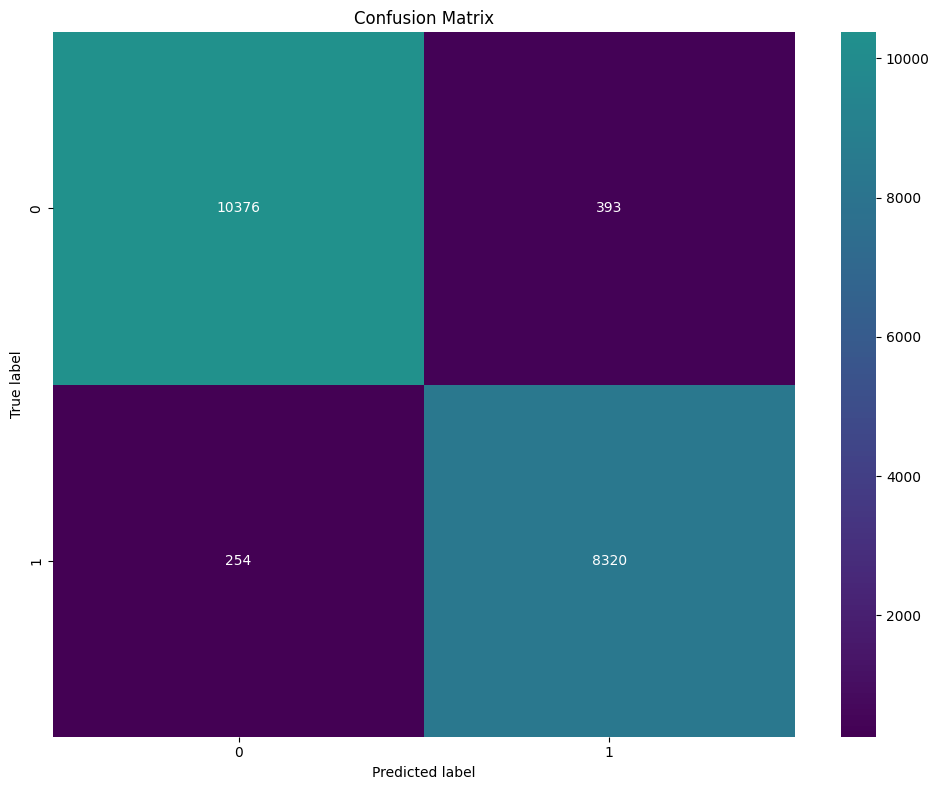

In [31]:
report, misclassified_images = evaluate_model_seaborn(test_dataset,y_true,y_preds)

In [32]:
report

{'accuracy': 0.9665512071550432,
 'f1_score': np.float64(0.9665770479130315),
 'matthews_corrcoef': np.float64(0.9324400176377955),
 'classification_report': {'0': {'precision': 0.9761053621825023,
   'recall': 0.9635063608505896,
   'f1-score': 0.9697649422870228,
   'support': 10769.0},
  '1': {'precision': 0.9548949845059107,
   'recall': 0.9703755540004665,
   'f1-score': 0.9625730317579684,
   'support': 8574.0},
  'accuracy': 0.9665512071550432,
  'macro avg': {'precision': 0.9655001733442066,
   'recall': 0.9669409574255281,
   'f1-score': 0.9661689870224957,
   'support': 19343.0},
  'weighted avg': {'precision': 0.9667036262470684,
   'recall': 0.9665512071550432,
   'f1-score': 0.9665770479130315,
   'support': 19343.0}}}

In [35]:
from keras.models import load_model,save_model
modelname="hybridfcnmlp"
fcn_model = save_model(model=fcn_model,filepath=f"./checkpoints/{modelname}.keras")
fcn_model = load_model(f"./checkpoints/{modelname}.keras")

In [ ]:
import numpy as np
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
final_images=[]
preds = []
labels = []
captions = []
for image in misclassified_images[:8]:
    heatmap = make_gradcam_heatmap(model=fcn_model,
                         last_conv_layer_name="functional_1",
                         img_array=image[0],
                         )
    pred= np.argmax(fcn_model.predict(image[0]),axis=1)
    preds.append(pred[0])
    final = superimpose_gradcam(heatmap=heatmap, img=image[0][0],alpha=1)
    final_images.append(final)
    captions.append(f"Predicted: {image[2]}, True: {image[1]}")
p=plot_images_grid(final_images,captions = captions)
print(labels)
print(preds)

In [37]:
fcn_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 14, 14, 128)    │       274,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14, 14, 2)      │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,856 (1.05 MB)

 Trainable params: 258 (1.01 KB)

 Non-trainable params: 274,080 (1.05 MB)

 Optimizer params: 518 (2.03 KB)